In [ ]:
# prompt: mount drive, with force mount = True

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/My Drive/DS5500')

Mounted at /content/drive


In [ ]:
!python utils.py

In [ ]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelEncoder
import utils
from tqdm import tqdm
from joblib import Parallel, delayed

import warnings
warnings.filterwarnings('ignore')
from itertools import product
from multiprocessing import Pool


In [ ]:
#os.chdir('C:/Users/akhil/Desktop/Northeastern/DS5500_capstone')
df = pd.read_csv('audio_features.csv')

In [ ]:
fold_0_train = df.loc[df['fold'] != 0, df.columns[:-1]]
fold_0_test = df.loc[df['fold'] == 0, df.columns[:-1]]

fold_1_train = df.loc[df['fold'] != 1, df.columns[:-1]]
fold_1_test = df.loc[df['fold'] == 1, df.columns[:-1]]

fold_2_train = df.loc[df['fold'] != 2, df.columns[:-1]]
fold_2_test = df.loc[df['fold'] == 2, df.columns[:-1]]

fold_3_train = df.loc[df['fold'] != 3, df.columns[:-1]]
fold_3_test = df.loc[df['fold'] == 3, df.columns[:-1]]

fold_4_train = df.loc[df['fold'] != 4, df.columns[:-1]]
fold_4_test = df.loc[df['fold'] == 4, df.columns[:-1]]

fold_dfs = {0: [fold_0_train, fold_0_test],
            1: [fold_1_train, fold_1_test],
            2: [fold_2_train, fold_2_test],
            3: [fold_3_train, fold_3_test],
            4: [fold_4_train, fold_4_test]}

In [ ]:
for fold in range(5):
  train, test = fold_dfs[fold][0], fold_dfs[fold][1]
  print('Fold {}: Train shape = {}, Test shape = {}'.format(fold, train.shape, test.shape))


Fold 0: Train shape = (8481, 176), Test shape = (2121, 176)
Fold 1: Train shape = (8481, 176), Test shape = (2121, 176)
Fold 2: Train shape = (8482, 176), Test shape = (2120, 176)
Fold 3: Train shape = (8482, 176), Test shape = (2120, 176)
Fold 4: Train shape = (8482, 176), Test shape = (2120, 176)


In [ ]:
def data_conversion(data):
    train = data[0]
    test = data[1]

    X_train = train.drop('Label', axis=1)
    y_train = train['Label']

    X_test = test.drop('Label', axis=1)
    y_test = test['Label']

    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train.values)
    y_test = label_encoder.transform(y_test.values)

    label_mapping = \
    {label: encoding for label, encoding in zip(label_encoder.inverse_transform(np.unique(y_train)), np.unique(y_train))}

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    pca = PCA(n_components=0.99)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    return (X_train, X_test, y_train, y_test, label_mapping)

In [ ]:
#performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Hyperparameters','Train AUC ROC', 'Test AUC ROC'])
#model = LogisticRegression(max_iter = 2000)
def build_and_evaluate_model(model, X_train, X_test, y_train, y_test, hyperparameters, fold, model_name):

    try:
        model = model.set_params(**hyperparameters)
        model.fit(X_train, y_train)
        y_train_pred = model.predict_proba(X_train)
        y_test_pred = model.predict_proba(X_test)

        train_auc = roc_auc_score(y_train, y_train_pred, average='weighted', multi_class='ovr')
        print(f"Overall Train Data ROC-AUC: {train_auc:.2f}")
        test_auc = roc_auc_score(y_test, y_test_pred, average='weighted', multi_class='ovr')
        print(f"Overall Train Data ROC-AUC: {test_auc:.2f}")

        return model_name, fold, hyperparameters, train_auc, test_auc
    except ValueError as e:
        return model_name, fold, hyperparameters, None, None

In [ ]:
base_model = XGBClassifier()
model = OneVsRestClassifier(base_model)
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [6, 8, 10],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__colsample_bytree': [0.8, 1.0],
    'estimator__reg_alpha': [0, 0.01, 0.1],
    'estimator__reg_lambda': [0, 0.01, 0.1],
    'estimator__random_state': [42]
}

param_combinations = [dict(zip(param_grid.keys(), combo)) for combo in product(*param_grid.values())]
print(len(param_combinations))
num_processes = os.cpu_count()
print(num_processes)

486
8


In [ ]:
import time

start_time = time.time()
results = {}
for fold_ in fold_dfs.keys():
    print(fold_)
    X_train, X_test, y_train, y_test, label_mapping = data_conversion(fold_dfs[fold_])
    result = Parallel(n_jobs=num_processes)(delayed(build_and_evaluate_model)(
        model, X_train, X_test, y_train, y_test, params, fold_, 'XGBoost') for params in param_combinations)
    results[f'f{fold_}_result'] = result

end_time = time.time()
print(f"{(end_time - start_time)/60} minutes")

0
1
2
3
4
126.12067897319794 minutes


In [ ]:
f0 = pd.DataFrame(results['f0_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f0['diff'] = f0['Train ROC-AUC'] - f0['Test ROC-AUC']
f0.sort_values(by = 'diff', ascending=True, inplace=True)
f0 = f0[f0['Test ROC-AUC'] > 0.8]
f0.reset_index(inplace=True, drop=True)
f0.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,XGBoost,0,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925919,0.849999,0.075921
1,XGBoost,0,"{'estimator__n_estimators': 50, 'estimator__ma...",0.926289,0.850363,0.075926
2,XGBoost,0,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925892,0.849858,0.076034
3,XGBoost,0,"{'estimator__n_estimators': 50, 'estimator__ma...",0.926050,0.849833,0.076217
4,XGBoost,0,"{'estimator__n_estimators': 50, 'estimator__ma...",0.926228,0.849833,0.076395


In [ ]:
f1 = pd.DataFrame(results['f1_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f1['diff'] = f1['Train ROC-AUC'] - f1['Test ROC-AUC']
f1.sort_values(by = 'diff', ascending=True, inplace=True)
f1 = f1[f1['Test ROC-AUC'] > 0.8]
f1.reset_index(inplace=True, drop=True)
f1.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912471,0.851610,0.060861
1,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912385,0.851048,0.061337
2,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912872,0.851518,0.061353
3,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912955,0.851225,0.061730
4,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.913154,0.851415,0.061739


In [ ]:
f2 = pd.DataFrame(results['f2_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f2['diff'] = f2['Train ROC-AUC'] - f2['Test ROC-AUC']
f2.sort_values(by = 'diff', ascending=True, inplace=True)
f2 = f2[f2['Test ROC-AUC'] > 0.8]
f2.reset_index(inplace=True, drop=True)
f2.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,XGBoost,2,"{'estimator__n_estimators': 50, 'estimator__ma...",0.914721,0.849639,0.065081
1,XGBoost,2,"{'estimator__n_estimators': 50, 'estimator__ma...",0.914664,0.849568,0.065096
2,XGBoost,2,"{'estimator__n_estimators': 50, 'estimator__ma...",0.914753,0.849600,0.065154
3,XGBoost,2,"{'estimator__n_estimators': 50, 'estimator__ma...",0.915351,0.850171,0.065180
4,XGBoost,2,"{'estimator__n_estimators': 50, 'estimator__ma...",0.915246,0.849887,0.065359


In [ ]:
f3 = pd.DataFrame(results['f3_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f3['diff'] = f3['Train ROC-AUC'] - f3['Test ROC-AUC']
f3.sort_values(by = 'diff', ascending=True, inplace=True)
f3 = f3[f3['Test ROC-AUC'] > 0.8]
f3.reset_index(inplace=True, drop=True)
f3.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,XGBoost,3,"{'estimator__n_estimators': 50, 'estimator__ma...",0.918348,0.851264,0.067083
1,XGBoost,3,"{'estimator__n_estimators': 50, 'estimator__ma...",0.917896,0.850755,0.067141
2,XGBoost,3,"{'estimator__n_estimators': 50, 'estimator__ma...",0.929155,0.862011,0.067144
3,XGBoost,3,"{'estimator__n_estimators': 50, 'estimator__ma...",0.917962,0.850788,0.067174
4,XGBoost,3,"{'estimator__n_estimators': 50, 'estimator__ma...",0.918055,0.850841,0.067213


In [ ]:
f4 = pd.DataFrame(results['f4_result'], columns=['Model', 'Fold','Hyperparameters', 'Train ROC-AUC', 'Test ROC-AUC'])
f4['diff'] = f4['Train ROC-AUC'] - f4['Test ROC-AUC']
f4.sort_values(by = 'diff', ascending=True, inplace=True)
f4 = f4[f4['Test ROC-AUC'] > 0.8]
f4.reset_index(inplace=True, drop=True)
f4.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,XGBoost,4,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925288,0.860247,0.065041
1,XGBoost,4,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925476,0.860258,0.065219
2,XGBoost,4,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925584,0.859981,0.065602
3,XGBoost,4,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925492,0.859793,0.065699
4,XGBoost,4,"{'estimator__n_estimators': 50, 'estimator__ma...",0.925805,0.860100,0.065705


In [ ]:
final_error_df = pd.concat((f0, f1, f2, f3, f4))
final_error_df.sort_values(by = 'diff', inplace=True, ascending=True)
final_error_df.reset_index(inplace=True, drop=True)
final_error_df.head()

,Model,Fold,Hyperparameters,Train ROC-AUC,Test ROC-AUC,diff
0,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912471,0.851610,0.060861
1,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912385,0.851048,0.061337
2,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912872,0.851518,0.061353
3,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.912955,0.851225,0.061730
4,XGBoost,1,"{'estimator__n_estimators': 50, 'estimator__ma...",0.913154,0.851415,0.061739


In [ ]:
final_error_df.to_csv('Results/Random_Forest_all_folds_errors.csv', index=False, header=True)

In [ ]:
performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Train AUC ROC', 'Test AUC ROC'])
hyperparameters = final_error_df.loc[0, 'Hyperparameters']
print(hyperparameters)
X_train, X_test, y_train, y_test, label_mapping = data_conversion(fold_dfs[0])
base_model = XGBClassifier()
model = OneVsRestClassifier(base_model)
model = model.set_params(**hyperparameters)
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)
y_test_pred = model.predict_proba(X_test)

{'estimator__n_estimators': 50, 'estimator__max_depth': 6, 'estimator__learning_rate': 0.01, 'estimator__colsample_bytree': 1.0, 'estimator__reg_alpha': 0.1, 'estimator__reg_lambda': 0.1, 'estimator__random_state': 42}


In [ ]:
def generate_performance_values_plots(train_vals, test_vals, label_mapping, performance_metric_values, model_name, fold):
    f0_train_auc = roc_auc_score(train_vals[0], train_vals[1], average='weighted', multi_class='ovr')
    print(f"Overall Train Data ROC-AUC: {f0_train_auc:.2f}")
    f0_test_auc = roc_auc_score(test_vals[0], test_vals[1], average='weighted', multi_class='ovr')
    print(f"Overall Train Data ROC-AUC: {f0_test_auc:.2f}")

    error_series = pd.Series([model_name, fold, f0_train_auc, f0_test_auc], index= performance_metric_values.columns)
    #performance_metric_values = pd.concat((performance_metric_values, pd.DataFrame(error_series)))
    performance_metric_values.loc[len(df)] = error_series
    performance_metric_values.reset_index(inplace=True, drop=True)

    generate_plot(train_vals[0], train_vals[1], label_mapping, model_name, 'Train Data')
    generate_plot(test_vals[0], test_vals[1], label_mapping, model_name, 'Test Data')
    return performance_metric_values

def generate_plot(actual_classes, pred_classes, label_mapping, model_name, d_type):
    pred_classes = np.argmax(pred_classes, axis = 1)

    classes_ = list(label_mapping.values())
    # Binarize the predicted and true labels
    y_pred = label_binarize(pred_classes, classes= classes_)
    y_test = label_binarize(actual_classes, classes=classes_)

    n_classes = len(classes_)

    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    plt.figure(figsize = (12, 6))
    lw = 2
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=lw, label=f'Class {classes_[i]} (AUC = {roc_auc[i]:.2f})')

    # Compute micro-average ROC curve and ROC-AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calculate weighted ROC-AUC
    weights = [roc_auc[i] * np.sum(y_test[:, i]) / np.sum(y_test) for i in range(n_classes)]
    roc_auc["weighted"] = sum(weights)


    # Plot the micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average (AUC = {:.2f})'.format(roc_auc["micro"]),
            color='deeppink', linestyle=':')

    # Plot the weighted ROC-AUC
    plt.plot([0], [0], 'w', label='Weighted (AUC = {:.2f})'.format(roc_auc["weighted"]))

    # Add a diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC Curve for {model_name} on {d_type}')
    plt.legend(loc="lower right")
    plt.show()

Overall Train Data ROC-AUC: 0.91
Overall Train Data ROC-AUC: 0.84


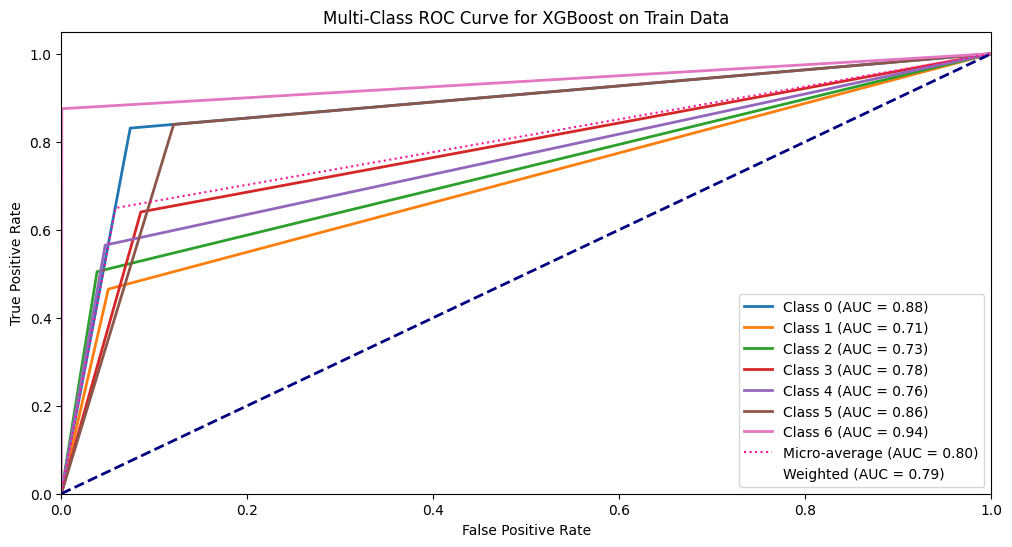

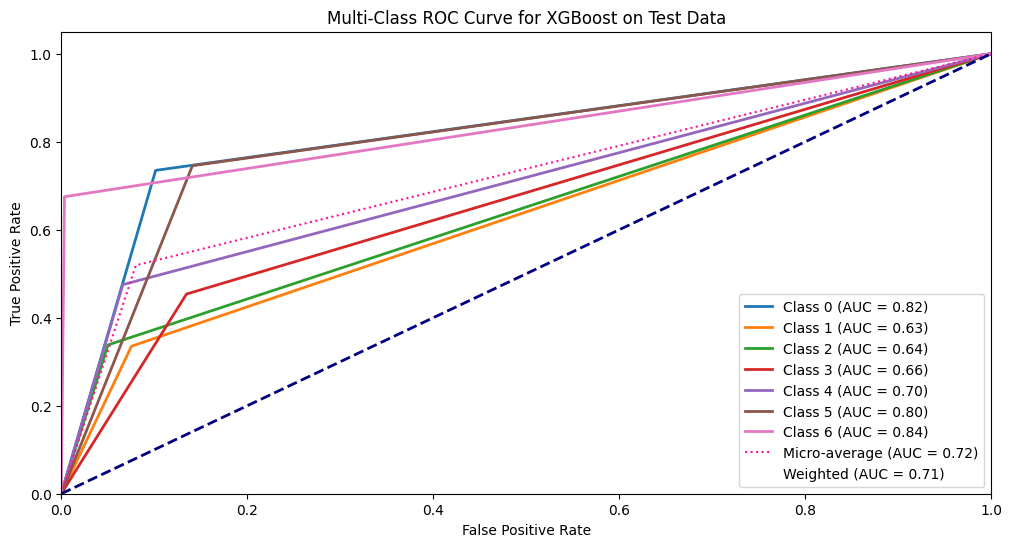

,Model,Fold,Train AUC ROC,Test AUC ROC
0,XGBoost,0,0.914935,0.837913


In [ ]:
train_vals = [y_train, y_train_pred]
test_vals = [y_test, y_test_pred]

performance_metric_values = pd.DataFrame(columns=['Model', 'Fold', 'Train AUC ROC', 'Test AUC ROC'])
generate_performance_values_plots(train_vals, test_vals, label_mapping, performance_metric_values, 'XGBoost', 0)